In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [16]:
df= pd.read_csv("/content/MSFT.csv")
df1=df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,83.599998,84.809998,83.220001,84.260002,78.978004,29532100
1,2017-12-04,84.419998,84.430000,80.699997,81.080002,75.997337,39094900
2,2017-12-05,81.339996,82.680000,80.980003,81.589996,76.475357,26152300
3,2017-12-06,81.550003,83.139999,81.430000,82.779999,77.590767,26162100
4,2017-12-07,82.540001,82.800003,82.000000,82.489998,77.318954,23184500
...,...,...,...,...,...,...,...
1386,2023-06-07,331.649994,334.489990,322.500000,323.380005,323.380005,40717100
1387,2023-06-08,323.940002,326.640015,323.350006,325.260010,325.260010,23277700
1388,2023-06-09,324.989990,329.989990,324.410004,326.790009,326.790009,22514900
1389,2023-06-12,328.579987,332.100006,325.160004,331.850006,331.850006,24260300


In [17]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [19]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [22]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 4s 93ms/step - loss: 0.0463 - val_loss: 0.0029
Epoch 2/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0089 - val_loss: 0.0119
Epoch 3/100
14/14 [==============================] - 1s 59ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 4/100
14/14 [==============================] - 1s 59ms/step - loss: 9.8920e-04 - val_loss: 9.7419e-04
Epoch 5/100
14/14 [==============================] - 1s 59ms/step - loss: 3.1719e-04 - val_loss: 0.0011
Epoch 6/100
14/14 [==============================] - 1s 59ms/step - loss: 2.4963e-04 - val_loss: 9.3577e-04
Epoch 7/100
14/14 [==============================] - 1s 59ms/step - loss: 2.4101e-04 - val_loss: 0.0011
Epoch 8/100
14/14 [==============================] - 1s 58ms/step - loss: 2.2026e-04 - val_loss: 9.1666e-04
Epoch 9/100
14/14 [==============================] - 1s 58ms/step - loss: 2.1835e-04 - val_loss: 8.8551e-04
Epoch 10/100
14/14 [==============================] - 1s 58m

In [24]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 11ms/step


In [25]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [26]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs((y_pred_val - yval)))
test_mae = np.mean(np.abs((y_pred - ytest)))
valid_mape = np.mean(np.abs((y_pred_val - yval)/yval))
test_mape = np.mean(np.abs((y_pred - ytest)/ytest))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 311.2353700575893
Testing RMSE: 266.0208081969592
Validation MAE: 310.84550703568704
Testing MAE: 265.0967052091909
Validation MAPE: 354.0682641651022
Testing MAPE: 384.84122023855986


In [27]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
n_stepss=80
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_stepss, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.963775]
81
[0.963775]
82
[0.963775]
83
[0.963775]
84
[0.963775]
85
[0.963775]
86
[0.963775]
87
[0.963775]
88
[0.963775]
89
[0.963775]
90
[0.963775]
91
[0.963775]
92
[0.963775]
93
[0.963775]
94
[0.963775]
95
[0.963775]
96
[0.963775]
97
[0.963775]
98
[0.963775]
99
[0.963775]
100
[0.963775]
101
21 day input [0.65484871 0.65042172 0.66286308 0.64168229 0.64526968 0.64244555
 0.63042405 0.6488952  0.66484755 0.6708774  0.6604969  0.65877955
 0.65351302 0.63927796 0.65961916 0.68583757 0.7035836  0.74464765
 0.75697441 0.7294967  0.73541201 0.72972568 0.7502195  0.76132511
 0.74533456 0.74094578 0.76109614 0.77460596 0.79082548 0.78674206
 0.78655117 0.77571273 0.80341952 0.79498541 0.76995    0.77246881
 0.7967027  0.78258225 0.79273365 0.79109265 0.79139802 0.78246764
 0.78113201 0.76590467 0.74167089 0.81780715 0.85390986 0.86318369
 0.85669584 0.85612341 0.85226885 0.85612341 0.87612108 0.86848837
 0.8621914  0.88245625 0.87406021 0.86970963 0.8715796  0.8802809
 0.8889059  0.90615579

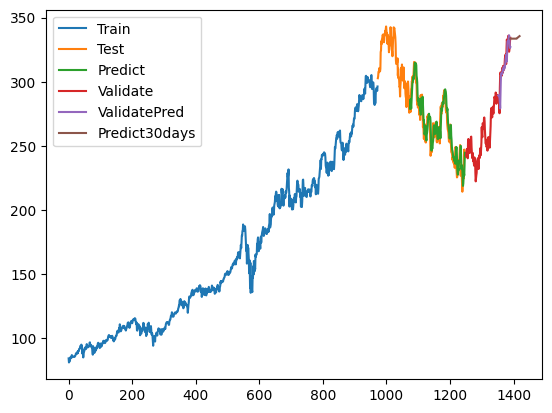

In [28]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()